# Определение стоимости автомобилей

Исследование содержит данные сервиса по продаже автомобилей с пробегом, включая технические характеристики, комплектации и цены автомобилей. Основная задача — разработать модель для оценки рыночной стоимости автомобилей на основе имеющихся данных.

**Цель исследования:**

1) Построить модель машинного обучения для точного предсказания рыночной стоимости автомобилей на основе их характеристик.
2) Оценить модель по трем критериям: качество предсказания и время, затрачиваемое на обучение и предсказание.

Таким образом, исследование пройдёт в **шесть этапов**:
1) Обзор данных
2) Предобработка данных
3) Исследовательский анализ данных
4) Корреляционный анализ данных
5) Обучение моделей
6)  Анализ результатов. Выбор лучшей модели

 **Условия проекта**:
- Для оценки качества моделей применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

## Загрузка и импорт библиотек

In [1]:
# Загрузка необходимых библиотек
!pip install optuna
!pip install lightgbm
!pip install shap phik
!pip install optuna-integration[sklearn]
!pip install -U scikit-learn
!pip install matplotlib==3.8.0
!pip install seaborn --upgrade

     |████████████████████████████████| 362 kB 69 kB/s eta 0:00:011
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 686 kB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 13.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 65.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 11.6 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 321 kB 64.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 71.

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import optuna
import time
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from optuna.integration import OptunaSearchCV

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию и описательную статистику DataFrame.

    '''
    display(df.head())
    df.info()
    display(df.describe().round(3))

In [4]:
def plt_hist_boxplt(column, title, label, bins=20, 
                     hue=None, xlim=None, color=None):
    '''
    Строит гистограмму и диаграмму размаха для указанного столбца DataFrame.
    
    Args:
        column (str): Столбец, для которого будут строиться графики.
        title (str): Заголовок для графиков.
        label (str): Название оси x для обоих графиков.
        hue (str): Кательгориальный столбец для разбивки. По умолчанию None
        bins (int, optional): Количество бинов для гистограммы. По умолчанию 20.
        xlim (tuple, optional): Пределы для оси x. По умолчанию None.
        color (str, optional): Цвет графиков. По умолчанию None.
    '''
    
    # Описательные статистики
    print(f'Описательные статистики параметра {title}')
    #display(pd.DataFrame(autos[column].describe()).T.style.format(precision=3))
    display(pd.DataFrame(autos[column].describe()).T.style.set_precision(3))
    
    # Построение графиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    # Гистограмма
    sns.histplot(data=autos, x=column, hue=hue, bins=bins, ax=ax1, color=color)
    ax1.set_title(f'Гистограмма - {title}', fontsize=14)
    ax1.set_xlabel(label)
    ax1.set_ylabel('Частота')
    ax1.set_xlim(xlim)

    # Диаграмма размаха
    sns.boxplot(data=autos, x=hue, y=column, ax=ax2, color=color, width=.5)
    ax2.set_title(f'Диаграмма размаха - {title}', fontsize=14)
    ax2.set_ylabel(label)
    ax2.set_xlim(xlim)

    plt.tight_layout()
    plt.show()

In [5]:
def plt_bar_box(column, xlabel, title, values='model', aggfunc='count', ylabel='Количество',
                figsize=(14, 5), display_pivot=False, display_bar_label=False):
    '''
    Создает вертикальную столбчатую диаграмму и боксплот для цены по категориям.

    Args:
        column (str): Столбец для построения сводной таблицы и диаграмм.
        xlabel (str): Название оси x для барплота.
        title (str): Заголовок барплота.
        values (str, optional): Столбец для агрегации в сводной таблице. По умолчанию 'model'.
        aggfunc (str or function, optional): Функция агрегации для сводной таблицы. По умолчанию 'count'.
        ylabel (str, optional): Название оси y для барплота. По умолчанию 'Количество'.
        figsize (tuple, optional): Размеры фигуры (ширина, высота). По умолчанию (14, 5).
        display_pivot (bool, optional): Отображать сводную таблицу перед построением диаграмм. По умолчанию False.
        display_bar_label (bool, optional): Добавлять метки на столбики барплота. По умолчанию False.
    '''

    # Сводная таблица
    column_pivot_bar = (
        autos
        .pivot_table(index=column, values=values, aggfunc=aggfunc)
        .reset_index()
        .sort_values(by=values, ascending=False)
    )
    
    if display_pivot:
        display(column_pivot_bar)

    # Построение графиков
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Столбчатая диаграмма
    ax1 = sns.barplot(data=column_pivot_bar, x=column, y=values, palette='muted', ax=axes[0])
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    ax1.set_title(title, fontsize=14)

    # Метки с абсолютными значениями на столбики
    if display_bar_label:
        for container in ax1.containers:
            ax1.bar_label(container, fontsize=10)

    # Диаграмма размаха
    ax2 = sns.boxplot(data=autos, x=column, y='price', palette='muted', ax=axes[1])
    ax2.set_ylabel('Евро')
    ax2.set_xlabel(xlabel)
    ax2.set_title(f'Диаграмма размаха цены - {title}')

    plt.tight_layout()
    plt.show()

In [6]:
def plt_barh(column, ylabel, title, values='fuel_type', aggfunc='count', xlabel='Количество', 
            figsize=(14, 5), head=15, display_bar_label=False):
    '''
    Создает горизонтальную столбчатую диаграмму для указанного столбца DataFrame.
    
    Args:
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        xlabel (str): Название оси x для диаграммы.
        title (str): Заголовок диаграммы.
        values (str, optional): Столбец для агрегации в сводной таблице. По умолчанию 'model'.
        aggfunc (str or function, optional): Функция агрегации для сводной таблицы. По умолчанию 'count'.
        ylabel (str, optional): Название оси y для диаграммы. По умолчанию 'Количество'.
        figsize (tuple, optional): Размеры фигуры (ширина, высота). По умолчанию (14, 5).
        display_bar_label (bool, optional): Добавлять метки на столбики барплота. По умолчанию False.
    '''
    
    # Сводная таблица
    column_pivot_bar = (
        autos
        .pivot_table(index=column, values=values, aggfunc=aggfunc)
        .reset_index()
        .sort_values(by=values, ascending=False)
        .head(head)
    )

    # Столбчатая диаграмма
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=column_pivot_bar, y=column, x=values, palette='muted')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title, fontsize=14)

    # Метки с абсолютными значениями на столбики
    if display_bar_label:
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
    
    plt.show()

## Загрузка и обзор данных

In [7]:
# Загрузка данных
try:
    autos = pd.read_csv('autos.csv', 
                        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    autos = pd.read_csv('/datasets/autos.csv', 
                        parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [8]:
# Вывод общей информации о датафрейме
data_info(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.0,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.0,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.0,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.0,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.0,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.0,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.0,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.0,99998.000


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Датафрейм содержит 354 369 строк с информацией о технических характеристиках, комплектации и ценах автомобилей.
- В данных присутствуют пропуски, а также аномальные значения.
- В данных могут содержатся дубликаты.
- Датафрейм содержит неинформативные для анализа и прогноза признаки.

Для дальнейшей работы с данными выполним их предобработку.

## Предобработка данных

### Удаление неинформативных признаков

В датафрейме присутствует ряд признаков неинформативных для дальнейшего анализа и обучения модели прогнозирования цены. Это признаки, связанные с пользователями и деталями скачивания данных:
- `DateCrawled` — дата скачивания анкеты из базы
- `DateCreated` — дата создания анкеты
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Удалим указанные столбцы из датафрейма. Также удалим столбец `NumberOfPictures` (количество фотографий автомобиля), т.к. все значения в нем равны 0.

In [9]:
# Количество уникальных значений в столбце 'NumberOfPictures'
autos['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [10]:
# Удаление неинформативных столбцов
autos = autos.drop(['NumberOfPictures', 
                    'DateCrawled', 
                    'DateCreated', 
                    'PostalCode', 
                    'LastSeen'], axis=1)
autos.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes


### Переименование столбцов

Приведем названия столбцов к нижнему регистру и к стилю snake_case:

In [11]:
# Приведение названий столбцов к нижнему регистру и формату snake_case
autos.columns = autos.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

autos.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

### Обработка пропусков

In [12]:
# Подсчет количества пропусков в каждом столбце
print('Количество пропусков:',
      autos.isna().sum(), sep='\n')

# Вывод доли пропущенных значений для каждого столбца
pd.DataFrame(autos.isna().mean()*100).style.set_precision(2).background_gradient('PuBu')

Количество пропусков:
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
dtype: int64


,0
price,0.00
vehicle_type,10.58
registration_year,0.00
gearbox,5.60
power,0.00
model,5.56
kilometer,0.00
registration_month,0.00
fuel_type,9.28
brand,0.00


Наблюдаем большое количество пропусков. Для начала проверим, сколько данных содержат пропуски одновременно во всех выделенных столбцах. Это может говорить о сбое при выгрузке данных или проблемах при заполнении анкеты пользователем.

In [13]:
# Строки с пропусками в 5 столбцах
missing_columns  = ['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']
autos[autos[missing_columns].isna().all(axis=1)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN


Обнаружили 2237 строк с пропусками в ключевых для ценообразования признаках. Т.к. восстановить данные не представляется возможным, а заполнение пропусков при отсутствии половины характеристик считаем нецелесообразным, избавимся от них:

In [14]:
# Удаление строк
autos.dropna(subset=missing_columns, how='all', inplace=True)

# Вывод результата
pd.DataFrame(autos.isna().mean()*100).style.set_precision(2).background_gradient('PuBu')

,0
price,0.00
vehicle_type,10.01
registration_year,0.00
gearbox,5.00
power,0.00
model,4.96
kilometer,0.00
registration_month,0.00
fuel_type,8.71
brand,0.00


- `repaired`. Посколько пропуски составляют практически 20% всего датасета, их удаление повлечет за собой потерю большой части данных, а замена на моду - искажение распределения данных и снижение точности анализа. Поэтому пропущенные значения заменим на значение **'no_info'**.
- `gearbox`. Также заменим пропуски на **'no_info'**.
- `model`. Модель автомобиля является одним из ключевых факторов в ценообразовании. Т.к. возможности достоверно восстановить данные нет (используя другие характеристики авто), и их количество составляет 4,96% от всего датасета, **удалим** пропущенные значения.
- `vehicle_type`, `fuel_type`. Пропуски по каждому признаку составляют около 10%, что является значительной частью датасета. Удалять их или заменять модой будет не лучшей стратегией. Заменим пропуски на **'no_info'**.

*Примечание*. В столбцах `vehicle_type`, `fuel_type` встречается категория 'other'. Мы намеренно не записываем пропуски в эту категорию, чтобы явно показать, что пропуски означают отсутствие данных, а не 'другие' значения. Это позволит модели учесть этот важный аспект данных и принимать решения на основе более точной информации. Стоит учесть, что пропусков большое количество (свыше 30 тыс.) и их запись в категорию 'other' создаст искажение распределения данных.

In [15]:
# Удаление пропусков в столбце 'model'
autos_before = len(autos)
autos.dropna(subset=['model'], inplace=True)
autos_after = len(autos)

# Заполнение пропусков на 'no_info'
columns_to_fillna = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
autos[columns_to_fillna] = autos[columns_to_fillna].fillna('no_info')

# Проверка результатов
print('Количество пропусков:', autos.isna().sum(), sep='\n', end='\n\n')

# Вывод количества удалённых строк
print(f'Удалено строк: {autos_before - autos_after} ' 
      f'({((autos_before - autos_after) / autos_before) * 100:.2f}% от общего числа)')

Количество пропусков:
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

Удалено строк: 17468 (4.96% от общего числа)


### Обработка дубликатов

#### Обработка явных дубликатов

In [16]:
# Подсчет количества явных дубликатов
print(f'Количество явных дубликатов: {autos.duplicated().sum()} или '
      f'{autos.duplicated().sum() / len(autos) * 100:.2f} % от общего числа')

Количество явных дубликатов: 26370 или 7.88 % от общего числа


Удалим обнаруженные дубликаты после этапа EDA, перед обучением моделей.

#### Обработка неявных дубликатов

Также проверим наличие неявных дубликатов в столбцах с категориальными значениями.

In [17]:
# Уникальные значения категориальных столбцов
for column in autos.columns:
        if autos[column].dtypes == 'object':
            print(f'Уникальные значения в столбце {column}: {autos[column].unique()}', end='\n\n')

Уникальные значения в столбце vehicle_type: ['no_info' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe'
 'other']

Уникальные значения в столбце gearbox: ['manual' 'auto' 'no_info']

Уникальные значения в столбце model: ['golf' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octav

- В столбце `fuel_type` присутствуют неявные дубликаты - 'petrol' 'gasoline'. Это одно и то же, но в британском английском используется 'petrol', а в американском - 'gasoline'. Оставим 1 вариант - 'gasoline'.
- В столбцу `model` дублируются 'rangerover' и 'range_rover'. Оставим 1 вариант - 'range_rover'.

В других столбцах дубликатов не обнаружено.

In [18]:
# Замена дубликатов
autos['fuel_type'].replace('petrol', 'gasoline', inplace=True)
autos['model'].replace('rangerover', 'range_rover', inplace=True)

# Проверка результатов
display(autos['fuel_type'].unique())
display(autos['model'].unique())

array(['gasoline', 'no_info', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

**В результате предобработки данных**:

- Было удалено 5 неинформативных признака ('NumberOfPictures', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen').
- Обработаны пропущенные значения. 19 705 строк (5,56 % всех данных) было удалено. Оставшиеся пропуски были заменены на значение 'no_info'.
- Было обнаружено 26 370 полных дубликатов или 7.88 % от всех данных. Удалим их после этапа EDA. Также были обработаны неявные дубликаты  в столбцах с категориальными значениями.

## Исследовательский анализ данных

Проанализируем более подробно все параметры. 

1) `price` - цена автомобиля (евро). Целевой признак.

Описательные статистики параметра Цена


,count,mean,std,min,25%,50%,75%,max
price,334664.000,4504.347,4531.439,0.000,1150.000,2800.000,6500.000,20000.000


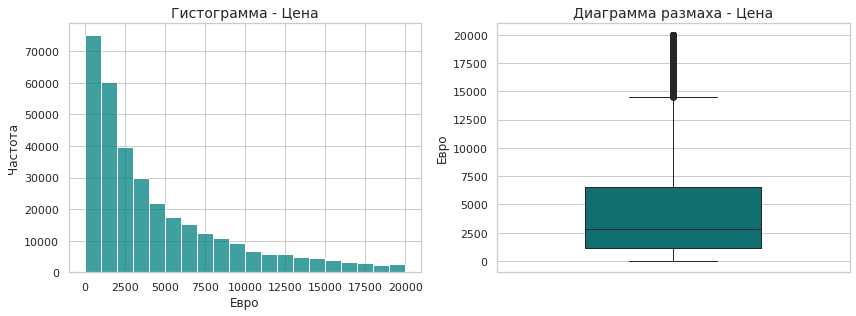

In [19]:
# Графики по столбцу 'price'
plt_hist_boxplt('price', title='Цена', label='Евро', bins=20, color='teal')

- Минимальное значение цены равно 0, что является явной ошибкой. Удалим данные значения. Помимо этого, избавимся от значений ниже 500 евро, т.к. купить подержанный автомобиль за эту сумму в 2016 году было крайне маловероятно. Такие цены могли встречаться лишь в редких случаях, например, для сильно повреждённых или полностью неработающих автомобилей, которые продавались на запчасти или для утилизации.

- На диаграмме размаха значения свыше 15 000 евро обозначены как выбросы. Однако эти цены не являются ошибочными и аномальными. Автомобили с высокими ценами представляют важную информацию о премиум-сегменте и элитных брендах, которые составляют достаточно значимую часть рынка. Удаление этих данных может исказить результаты анализа и результаты модели. Поэтому оставим их без изменений. 

In [20]:
# Удаление значений с ценой ниже 500 евро
autos_before = len(autos)
autos = autos.query('price > 500')
autos_after = len(autos)

# Вывод количества удалённых строк
print(f'Удалено строк: {autos_before - autos_after}')

Удалено строк: 36245


Описательные статистики параметра Цена


,count,mean,std,min,25%,50%,75%,max
price,298419.000,5021.778,4533.385,501.000,1500.000,3399.000,7000.000,20000.000


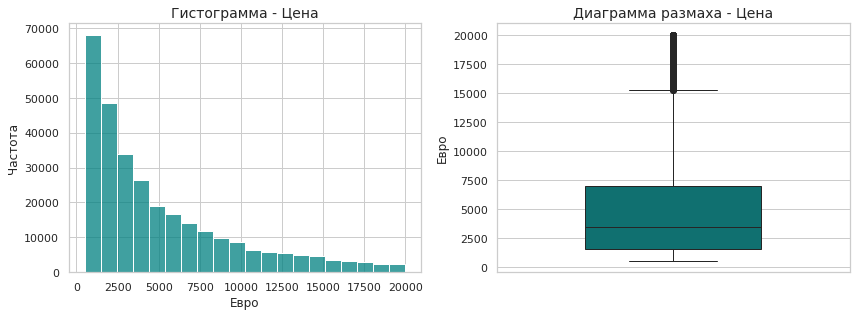

In [21]:
# Графики по столбцу 'price'
plt_hist_boxplt('price', title='Цена', label='Евро', bins=20, color='teal')

Медианное значение цены составляет **5 021 евро**. Большинство автомобилей продаются по ценам ниже 2500 евро, что можно наблюдать на гистограмме. 

2) `power` - мощность (л. с.).

Описательные статистики параметра Мощность


,count,mean,std,min,25%,50%,75%,max
power,298419.000,116.311,184.002,0.000,75.000,109.000,147.000,20000.000


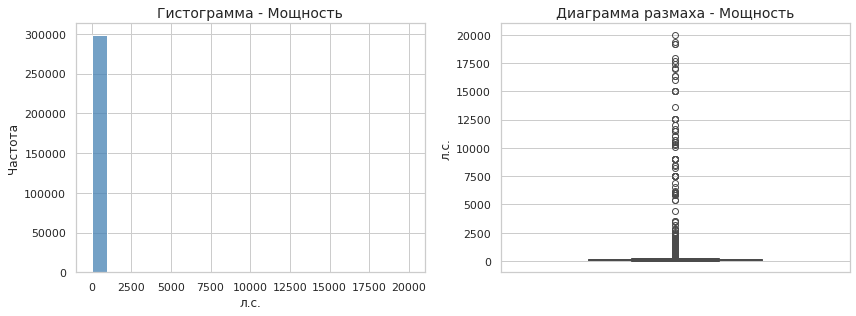

In [22]:
# Графики по столбцу 'power'
plt_hist_boxplt('power', title='Мощность', label='л.с.', bins=20, color='steelblue')

Оба графика неинформативные из-за наличия аномальных значений:
- Минимальное значение составляет 0 л.с., что является явной ошибкой. Причиной может служить сбой при выгрузке данных, либо пользователи при создании анкет не указали реальное значение. Т.к. восстановить данные не представляется возможным, удалим их.
- Также есть ошибочно высокие значения. Самые мощные современные авто не имеют значенйи свыше 4.5 тыс.л.с. ([ссылка](https://domcar.com.cy/live/blog/top-10-most-powerful-cars-in-the-world/)). Если же брать во внимание мощность стандартных легковых автомобилей, то значения свыше 800 встречаются крайне редко. Таким образом, удалим также значения превышающие 800 л.с.
- Помимо этого, удалим значения ниже 50 л.с., т.к. модели авто с указанной мощностью являются редкостью (самые компактные или раритетные модели)

In [23]:
# Удаление значений с мощностью менее 50 и более 800 л.с.
autos_before = len(autos)
autos = autos.query('(power < 800) and (power > 50)')
autos_after = len(autos)

# Вывод количества удалённых строк
print(f'Удалено строк: {autos_before - autos_after}')

Удалено строк: 31176


Описательные статистики параметра Мощность


,count,mean,std,min,25%,50%,75%,max
power,267243.000,125.084,52.861,51.000,86.000,116.000,150.000,776.000


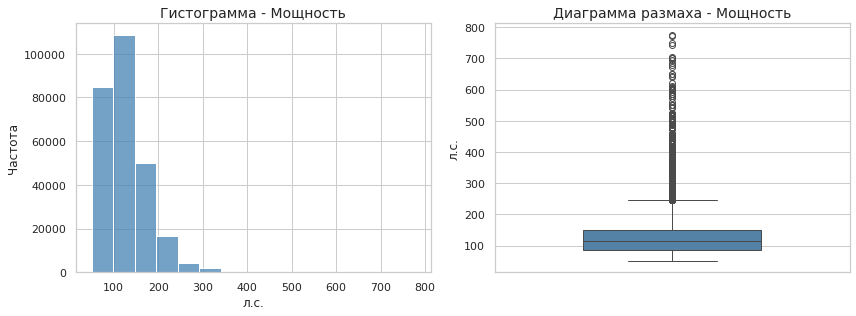

In [24]:
# Графики по столбцу 'power'
plt_hist_boxplt('power', title='Мощность', label='л.с.', bins=15, color='steelblue')

Медианное значение мощности составляет **125** лошадиных сил. Половина всех представленных авто имеют мощность 86-150 лошадиных сил.

3) `kilometer` - пробег (км).

Описательные статистики параметра Пробег


,count,mean,std,min,25%,50%,75%,max
kilometer,267243.000,127765.274,36784.389,5000.000,125000.000,150000.000,150000.000,150000.000


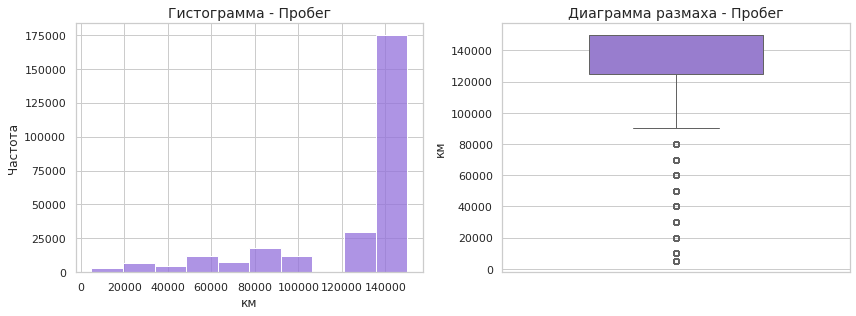

In [25]:
# Графики по столбцу 'kilometer'
plt_hist_boxplt('kilometer', title='Пробег', label='км', bins=10, color='mediumpurple')

Медианное значение составляет **127 765 км**. Подавляющая часть представленных авто имеют пробег свыше 120 000 км.
На диаграмме размаха значения ниже 90 000 км выделены как выбросы, однако они не являются аномальными или ошибочными. Оставим их без изменений.

4) `registration_year` - год регистрации автомобиля.

Описательные статистики параметра Год регистрации автомобиля


,count,mean,std,min,25%,50%,75%,max
registration_year,267243.000,2003.959,19.003,1000.000,2000.000,2004.000,2008.000,5911.000


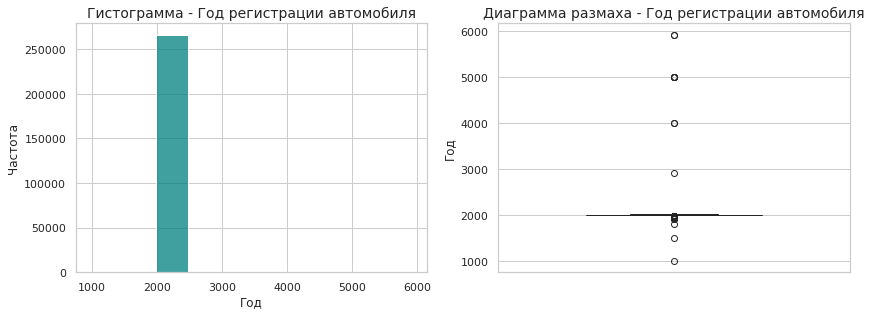

In [26]:
# Графики по столбцу 'registration_year'
plt_hist_boxplt('registration_year', title='Год регистрации автомобиля', 
                label='Год', bins=10, color='teal')

Оба графика малоинформативные из-за наличия аномальных  и ошибочных значений:
- Максимальное значение достигает 8200 лет. Т.к. данные были выгружены за 2016 год, следовательно в них не могут находится автомобили, выпущенные позже  этого года. Удалим значения, превыщаюшие 2016.
- Минимально значение 1000 год, что также является ошибкой. Автомобили, с момента производства которых прошло 30 лет или более, можно считать [раритетными](https://auto.ru/mag/article/kak-priznat-staruyu-mashinu-raritetom-i-zachem-eto-nuzhno/?utm_referrer=https%3A%2F%2Fwww.google.com%2F#part2). Удалим также данные с автомобилями старше 30 лет (год регистрации менее 1986 года).

In [27]:
# Удаление значений с годом регистрации менее 1986 и более 2016 года
autos_before = len(autos)
autos = autos.query('(registration_year <= 2016) and (registration_year >= 1986)')
autos_after = len(autos)

# Вывод количества удалённых строк
print(f'Удалено строк: {autos_before - autos_after}')

Удалено строк: 10849


Описательные статистики параметра Год регистрации автомобиля


,count,mean,std,min,25%,50%,75%,max
registration_year,256394.000,2003.687,5.469,1986.000,2000.000,2004.000,2008.000,2016.000


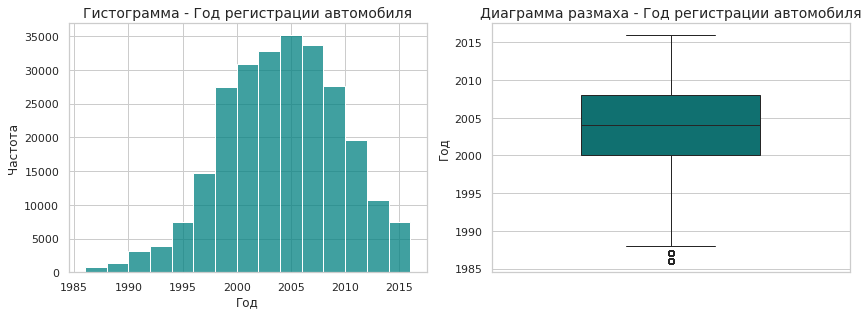

In [28]:
# Графики по столбцу 'registration_year'
plt_hist_boxplt('registration_year', title='Год регистрации автомобиля', 
                label='Год', bins=15, color='teal')

Среднее значение регистрации авто составляет **2003 год**. Основное количество автомобилей зарегистрированы в промежуток 2000-2008 года.

5) `registration_month` - месяц регистрации автомобиля.

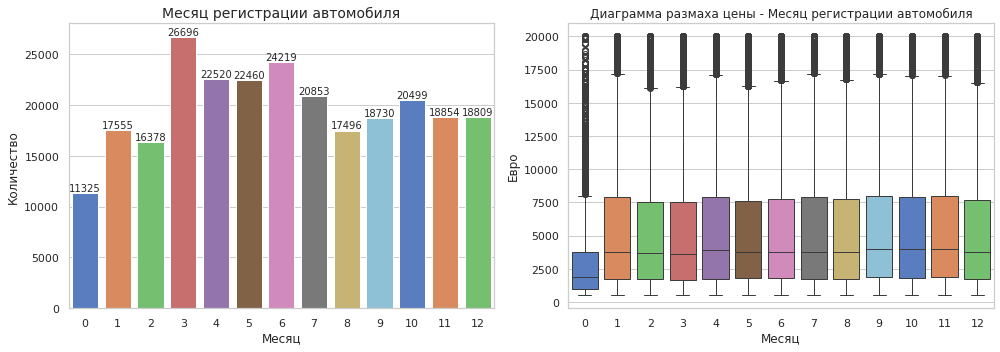

In [29]:
# Графики по столбцу 'registration_month'
plt_bar_box('registration_month', xlabel='Месяц', 
            title='Месяц регистрации автомобиля', display_bar_label=True)

Признак включает в себя 13 месяцев, что является ошибкой. Более 5% автомобилей с указанным 0-ым месяцем. Выявить природу появления неверного значения не представляется возможным. Заменять это значение на другое - нецелесообразно.

Что стоит отметить, так это распределение стоимости в зависимости от месяца. Видим, что месяц регистрации никак не влияет на цену - у всех автомобилей одинаковое распределение цен (не берем в расчет ошибочный нулевой месяц). Это говорит нам об отсутствии взавимосвязи между этими параметрами и  неинформативности данного признака для прознозирования цены. По этим причинами удалим столбец из датасета.

In [30]:
# Удаление столбца `registration_month`
autos = autos.drop(['registration_month'], axis=1)

autos.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_info
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no


6) `vehicle_type` - тип автомобильного кузова.

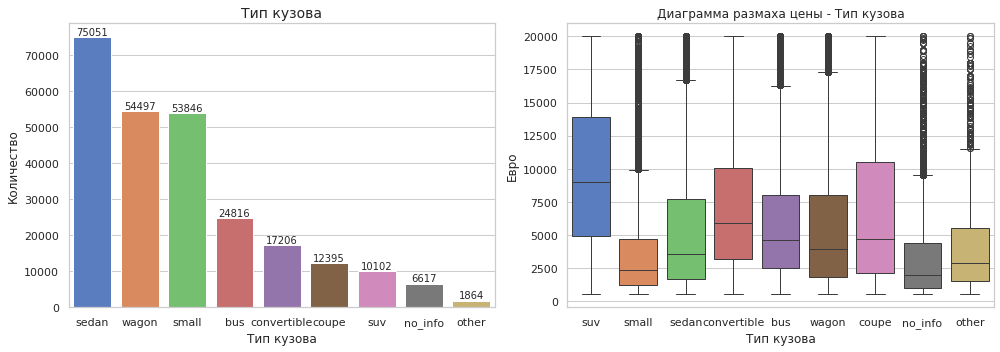

In [31]:
# Графики по столбцу 'vehicle_type'
plt_bar_box('vehicle_type', xlabel='Тип кузова', 
            title='Тип кузова', display_bar_label=True)

Самое большое количество автомобилей представлено в кузовах **sedan, small, wagon** (практически 70% всех данных). 

На диаграммах размаха наблюдаем, как распределение стоимости автомобиля зависит от типа кузова. Наиболее высокую среднюю цену показывает тип **suv** (~ 9000 евро). Самые же низкие цены - у автомобилей типов small, other (менее 2000 евро).

7) `gearbox` - тип коробки передач.

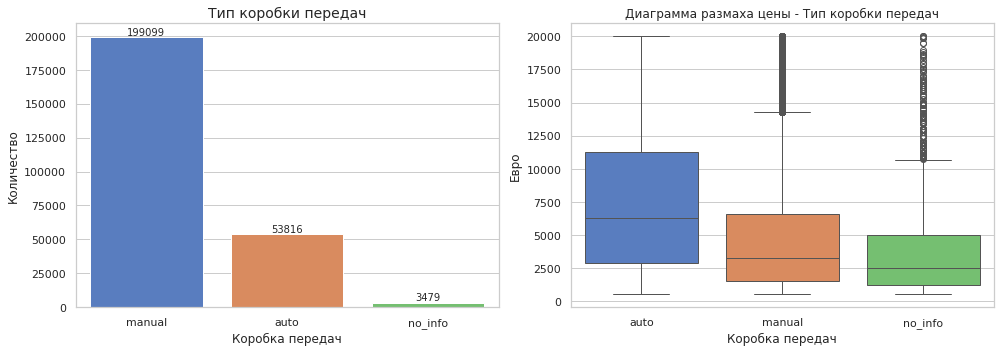

In [32]:
# Графики по столбцу 'gearbox'
plt_bar_box('gearbox', xlabel='Коробка передач', 
            title='Тип коробки передач', display_bar_label=True)

Свыше 78% из представленных автомобилей - с ручкой коробкой передач (**manual**). На диаграмме размаха видим, что автомобили с автоматической коробкой в среднем стоят дороже, чем с ручной (6000 и 2900 евро соответственно).

8) `fuel_type` - тип топлива.

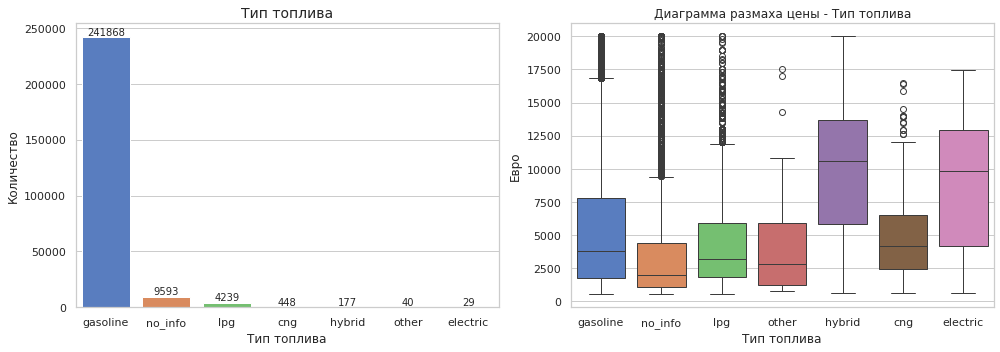

In [33]:
# Графики по столбцу 'fuel_type'
plt_bar_box('fuel_type', xlabel='Тип топлива', 
            title='Тип топлива', display_bar_label=True)

Подавляющее большинство автомобилей используют в качестве топлива **бензин (gasoline)**. По диаграмме размаха наблюдаем, что гибридные и электрические автомобили в среднем стоят дороже (~ 10000 евро), чем использующие другие типы топлива. 

9) `repaired` - была машина в ремонте или нет.

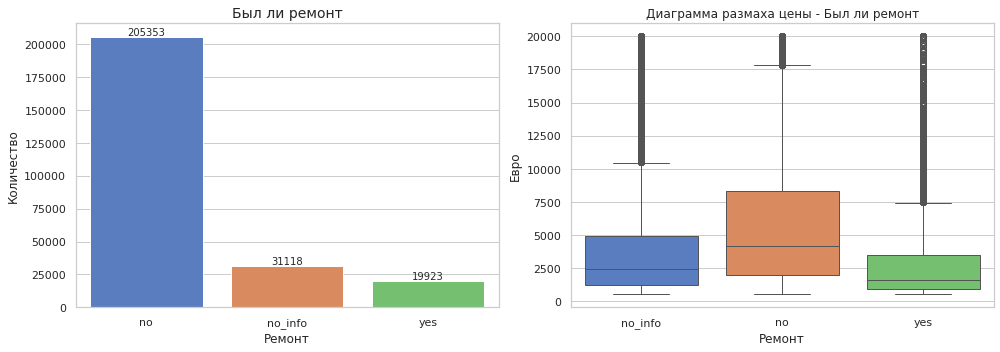

In [34]:
# Графики по столбцу 'repaired'
plt_bar_box('repaired', xlabel='Ремонт', 
            title='Был ли ремонт', display_bar_label=True)

В объявлениях около 75% автомобилей указано, что они **не были в ремонте**. На графике распределения цены видим, что такие автомобили в среднем стоят дороже (~ 4000 евро), чем побывавшие в ремонте (~ 1200 евро).

10) `brand` - марка автомобиля.

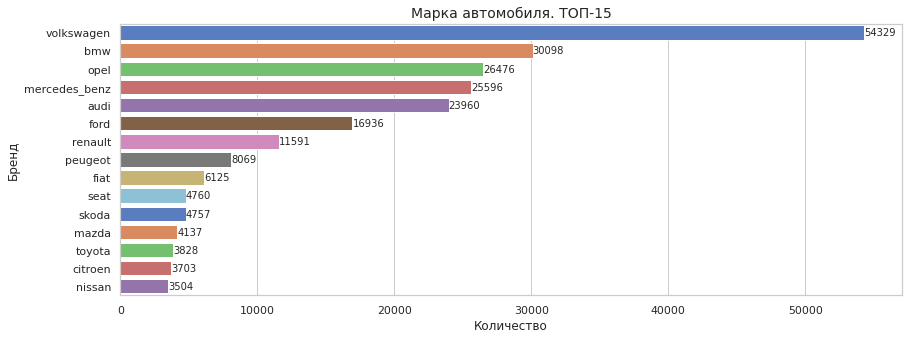

In [35]:
# График по столбцу 'brand'
plt_barh('brand', ylabel='Бренд', 
         title='Марка автомобиля. ТОП-15', display_bar_label=True)

Самым популярным брендом является **Volkswagen** - свыше 20% всех автомобилей. Второе и третье место занимают BMW, Opel.

11) `model` - модель автомобиля.

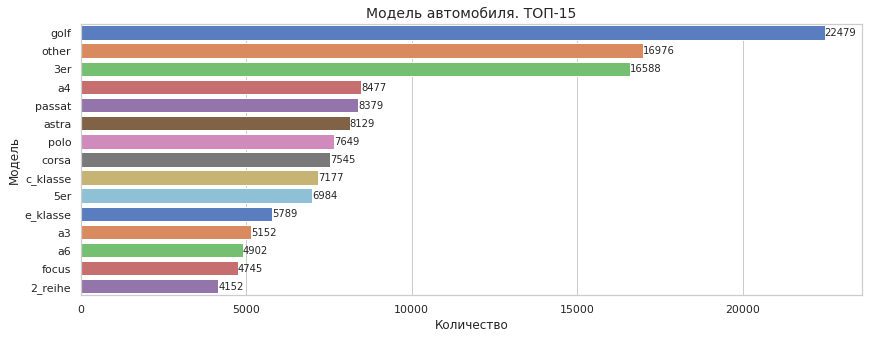

In [36]:
# График по столбцу 'model'
plt_barh('model', ylabel='Модель', 
         title='Модель автомобиля. ТОП-15', display_bar_label=True)

**Выводы:**

Рассмотрев основные характеристики автомобилей, мы проанализировали распределение значений по каждому параметру, выявили средние значения, а также аномальные. В результате:
- Удалили 23,4 % от всех данных по причине ошибочности и аномальности значений.
- Выявили неинформативный для прогнозирования цены автомобиля признак - месяц регистрации автомобиля (`registration_month`). В дальнейшем анализе не станем его использовать.
- Средняя стоимость автомобилей составляет 5 021 евро.
- Большая часть авто имеют мощность 86-150 лошадиных сил.
- Средний пробег составляет 127 765 км.
- Основная часть представленных автомобилей 2000-2008 гг. производства.
- Практически 70 % авто имеют типы кузова sedan, small, wagon.
- Более 78% авто с ручной коробкой передач.
- 75% автомобилей не были в ремонте.

## Корреляционный анализ

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции Фи и построим тепловую карту. Используем для расчета все количественные и качественные признаки.

In [37]:
# Расчет корреляции
autos_phik = autos.phik_matrix(interval_cols=['price', 'power']).round(3)

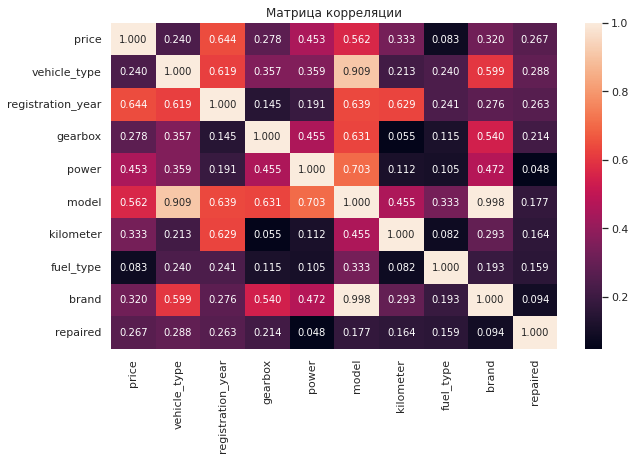

In [38]:
# Тепловая карта
plt.figure(figsize=(10,6))
sns.heatmap(autos_phik, annot=True, fmt='.3f', annot_kws={"size": 10})
plt.title('Матрица корреляции')
plt.show()

**Выводы:**

Проанализировав матрицу корреляции, выявили следующие взаимосвязи:
- Целевой признак `price` показывает заметный уровень корреляции с признаками `registration_year` (коэффициент 0.644), `model` (0.562), `power` (0.453). С остальными признаками имеет умеренный и слабый уровень корреляции.
- Наличие мультиколлениарности между признаками `brand` и `model` (коэффициент 0.998). Т.к. для обучения мы будем использовать такие модели, как случайный лес и градиентный бустинг, удалять коррелирующие признаки не станем. Такие модели менее чувствительны к мультиколлинеарности, так как не используют линейные зависимости между признаками.

## Подготовка данных 

Удалим полные дубликаты, обнаруженные на этапе предобработки данных:

In [39]:
# Удаление дубликатов
autos.drop_duplicates(inplace=True)

# Проверка результатов
print(f'Количество явных дубликатов: {autos.duplicated().sum()}')

Количество явных дубликатов: 0


Разделим данные на тренировочную и тестовую выборки.

In [40]:
# Объявление констант
RANDOM_STATE = 42

# Разделение на целевой и входные признаки
X = autos.drop(['price'], axis=1)
y = autos['price']

# Разделение данных на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE
)


# Размерность выборок
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (165588, 9) (165588,)
Размер тестовой выборки: (55197, 9) (55197,)


Выделим количественные признаки для масштабирования и категориальные - для кодирования:

In [41]:
# Списки с названиями столбцов для кодирования и масштабирования
num_columns = ['registration_year', 'power', 'kilometer']
cat_columns = ['vehicle_type', 'gearbox', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

Создадим пайплайн для подготовки данных.  Для масштабирования числовых признаков будет использован **StandardScaler**. Для кодирования категориальных - **OneHotEncoder** или **OrdinalEncoder** (в зависимости от используемой модели).

In [42]:
def make_pipeline(cat_columns, num_columns, cat_encoding, model):
    '''
    Создает пайплайн на основе предоставленных столбцов и модели.
    
    Args:
        cat_columns (list): категориальные столбцы.
        num_columns (list): числовые столбцы.
        cat_encoding (str): тип кодирования для категориальных столбцов ('ohe', 'ordinal', None).
        model (sklearn model): используемая модель.
    '''
    
    # Определение типа кодирования
    if cat_encoding == 'ohe':
        cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    
    elif cat_encoding == 'ordinal':
        cat_transformer = Pipeline([
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ])
    
    else:
        cat_transformer = 'passthrough'

    # Список трансформеров
    transformers = [
        ('cat', cat_transformer, cat_columns),
        ('num', StandardScaler(), num_columns)
    ]

    # Общий ColumnTransformer
    data_preprocessor = ColumnTransformer(transformers)

    # Итоговый пайплайн
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

    return pipe_final

Для подбора наилучших гиперпараметров для каждой модели будем использовать **OptunaSearchCV**. Также мы рассчитаем время обучения и прогнозирования модели. Для оценки качества моделей будет применяться метрика **RMSE**.

In [43]:
def best_model_optuna(model, param_distr, X_train, y_train,
                      random_state=RANDOM_STATE, n_trials=50, verbose=0):
    '''
    Проводит подбор гиперпараметров модели с помощью OptunaSearchCV и вычисляет ключевые метрики.

    Args:
        model (sklearn model): используемая модель.
        param_distr (dict): диапазон для поиска гиперпараметров Optuna.
        X_train (DataFrame): Признаки обучающей выборки.
        y_train (Series): Целевой признак обучающей выборки.
        random_state (int, optional): Значение для фиксации случайности. По умолчанию RANDOM_STATE.
        n_trials (int, optional): Количество итераций для OptunaSearchCV. По умолчанию 50.
        verbose (int, optional): Уровень детализации вывода. По умолчанию 0.
        
    Вывод:
        - Лучшие параметры модели.
        - RMSE на кросс-валидации.
        - Время на обучение модели.
        - Время на предсказание модели.
    '''
    
    # Настройка OptunaSearchCV
    optuna_search = OptunaSearchCV(
        estimator=model,
        param_distributions=param_distr,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        verbose=verbose
    )
    
    # Подбор параметров
    optuna_search.fit(X_train, y_train)

    # Модель с лучшими параметрами
    best_model = optuna_search.best_estimator_

    # Измерение времени на обучение модели
    start_train = time.time()
    best_model.fit(X_train, y_train)  
    end_train = time.time()
    train_time = end_train - start_train

    # Измерение времени прогноза модели
    start_predict = time.time()
    y_train_pred = best_model.predict(X_train)
    end_predict = time.time()
    predict_time = end_predict - start_predict

    # RMSE
    rmse_cv = -optuna_search.best_score_

    # Вывод результтатов
    print(f'Лучшие параметры: {optuna_search.best_params_}')
    print(f'Метрика RMSE на кросс-валидации: {rmse_cv}')
    print(f'Время на обучение модели: {train_time:.2f} секунд')
    print(f'Время на предсказание модели: {predict_time:.2f} секунд')
 
    return best_model, train_time, predict_time, rmse_cv

**Выводы:**

- Разделили данные на тренировочную и тестовую выборки.
- Создали пайплайн для подготовки данных к обучению (масштабирование и кодирование признаков).
- Написали функцию для поиска гиперпараметров модели с помощью OptunaSearchCV, а также расчета ключевых метрик.

## Обучение моделей

Для поиска лучшей модели протестируем 3 варианта:
- **Ridge Regression**
- **Random Forest Regressor**
- **LGBMRegressor**

### Ridge Regression

In [44]:
# Создание пайплайна для Ridge Regression
pipeline_ridge = make_pipeline(cat_columns, num_columns, 'ohe', Ridge(random_state=RANDOM_STATE))
pipeline_ridge

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'kilometer',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('model', Ridge(random_state=42))])

In [45]:
# Гиперпараметры для Ridge Regression
params_ridge = {
    'model__alpha': optuna.distributions.FloatDistribution(0.1, 1.5, 0.2),
}

In [46]:
# Подбор гиперпараметров и обучение модели
rigde_model, ridge_train_time, ridge_pred_time, ridge_rmse = best_model_optuna(
    pipeline_ridge, 
    params_ridge, 
    X_train, 
    y_train, 
    n_trials=10)

[I 2024-10-15 06:07:50,958] A new study created in memory with name: no-name-867ddd0a-7a34-49ca-a99a-57d0101bf6f2
[I 2024-10-15 06:08:05,367] Trial 0 finished with value: -2334.972633072687 and parameters: {'model__alpha': 0.34258625379596314}. Best is trial 0 with value: -2334.972633072687.
[I 2024-10-15 06:08:19,357] Trial 1 finished with value: -2334.980942568172 and parameters: {'model__alpha': 0.9533475508777948}. Best is trial 0 with value: -2334.972633072687.
[I 2024-10-15 06:08:33,563] Trial 2 finished with value: -2335.000293861101 and parameters: {'model__alpha': 0.12056206511512303}. Best is trial 0 with value: -2334.972633072687.
[I 2024-10-15 06:08:47,450] Trial 3 finished with value: -2334.9813960500146 and parameters: {'model__alpha': 0.23751941759036269}. Best is trial 0 with value: -2334.972633072687.
[I 2024-10-15 06:09:01,661] Trial 4 finished with value: -2334.9710371922624 and parameters: {'model__alpha': 0.3720697964349206}. Best is trial 4 with value: -2334.97103

Лучшие параметры: {'model__alpha': 0.3720697964349206}
Метрика RMSE на кросс-валидации: 2334.9710371922624
Время на обучение модели: 3.20 секунд
Время на предсказание модели: 1.20 секунд


### Random Forest Regressor

In [47]:
# Создание пайплайна для Random Forest
pipeline_random_forest = make_pipeline(cat_columns, num_columns, 'ordinal', 
                                       RandomForestRegressor(random_state=RANDOM_STATE))
pipeline_random_forest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'kilometer',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [48]:
# Гиперпараметры для RandomForestRegressor
params_rf = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 150),
    'model__min_samples_split': optuna.distributions.IntDistribution(2, 5)
}

In [49]:
# Подбор гиперпараметров и обучение модели
random_forest_model, random_forest_train_time, random_forest_pred_time, random_forest_rmse = best_model_optuna(
    pipeline_random_forest, 
    params_rf, 
    X_train, 
    y_train,
    n_trials=10,
    verbose=1)

[I 2024-10-15 06:10:20,135] A new study created in memory with name: no-name-e0cffc6a-587a-4f9f-bcbc-c9ed79c4fa8a
[I 2024-10-15 06:12:58,919] Trial 0 finished with value: -1628.2006636077524 and parameters: {'model__n_estimators': 95, 'model__min_samples_split': 5}. Best is trial 0 with value: -1628.2006636077524.
[I 2024-10-15 06:14:37,670] Trial 1 finished with value: -1644.7938764757007 and parameters: {'model__n_estimators': 56, 'model__min_samples_split': 3}. Best is trial 0 with value: -1628.2006636077524.
[I 2024-10-15 06:17:32,180] Trial 2 finished with value: -1641.4243393904555 and parameters: {'model__n_estimators': 99, 'model__min_samples_split': 3}. Best is trial 0 with value: -1628.2006636077524.
[I 2024-10-15 06:19:44,820] Trial 3 finished with value: -1652.1857719539148 and parameters: {'model__n_estimators': 71, 'model__min_samples_split': 2}. Best is trial 0 with value: -1628.2006636077524.
[I 2024-10-15 06:21:43,591] Trial 4 finished with value: -1643.5641842275813 a

Лучшие параметры: {'model__n_estimators': 136, 'model__min_samples_split': 5}
Метрика RMSE на кросс-валидации: 1627.251119994348
Время на обучение модели: 52.10 секунд
Время на предсказание модели: 7.89 секунд


### LGBMRegressor

In [50]:
# Создание пайплайна для LGBMRegressor
pipeline_lgbr = make_pipeline(cat_columns, num_columns, 'ordinal', 
                              LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
pipeline_lgbr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'kilometer',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('model', LGBMRegressor(random_state=42, verbose=-1))])

In [51]:
# Гиперпараметры для LGBMRegressor
params_lgbr = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 200),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'model__max_depth': optuna.distributions.IntDistribution(3, 10),
    'model__num_leaves': optuna.distributions.IntDistribution(20, 50)
}

In [52]:
# Подбор гиперпараметров и обучение модели
lgbr_model, lgbr_train_time, lgbrt_pred_time, lgbr_rmse = best_model_optuna(
    pipeline_lgbr, 
    params_lgbr, 
    X_train, 
    y_train, 
    n_trials=10)

[I 2024-10-15 06:37:56,109] A new study created in memory with name: no-name-3b122e90-10d0-468d-bbff-9ce0cbbfc7c5
[I 2024-10-15 06:38:09,965] Trial 0 finished with value: -1746.1985522410487 and parameters: {'model__n_estimators': 118, 'model__learning_rate': 0.2514632893713383, 'model__max_depth': 3, 'model__num_leaves': 29}. Best is trial 0 with value: -1746.1985522410487.
[I 2024-10-15 06:38:26,655] Trial 1 finished with value: -1757.757245081594 and parameters: {'model__n_estimators': 123, 'model__learning_rate': 0.0964958730958879, 'model__max_depth': 4, 'model__num_leaves': 25}. Best is trial 0 with value: -1746.1985522410487.
[I 2024-10-15 06:38:40,061] Trial 2 finished with value: -1735.1999049413862 and parameters: {'model__n_estimators': 76, 'model__learning_rate': 0.10237812053436175, 'model__max_depth': 5, 'model__num_leaves': 50}. Best is trial 2 with value: -1735.1999049413862.
[I 2024-10-15 06:39:20,561] Trial 3 finished with value: -1675.6449438710872 and parameters: {'

Лучшие параметры: {'model__n_estimators': 179, 'model__learning_rate': 0.29238538591217034, 'model__max_depth': 6, 'model__num_leaves': 49}
Метрика RMSE на кросс-валидации: 1572.5227313818912
Время на обучение модели: 5.70 секунд
Время на предсказание модели: 2.40 секунд


**Выводы:**

В результате было обучено 3 модели. Для каждой модели с помощью OptunaSearchCV были подобраны гиперпараметры, с которыми модель показывает наилучшую метрику RMSE. Гиперпараметры моделей:
- **Ridge Regression** - 'model__alpha': 0.3720697964349206
- **Random Forest Regressor** - 'model__n_estimators': 136, 'model__min_samples_split': 5
- **LGBMRegressor** - 'model__n_estimators': 179, 'model__learning_rate': 0.29238538591217034, 'model__max_depth': 6, 'model__num_leaves': 49

Также для каждой модели было рассчитано время, необходимое для обучения и предсказания модели.

## Анализ результатов. Выбор лучшей модели

Добавим результаты всех моделей в датафрейм и сравним их:

,model,RMSE,train_time,predict_time
0,Ridge Regression,2334.971037,3.196311,1.203904
1,Random Forest Regressor,1627.251120,52.104376,7.892619
2,LGBMRegressor,1572.522731,5.698036,2.404336


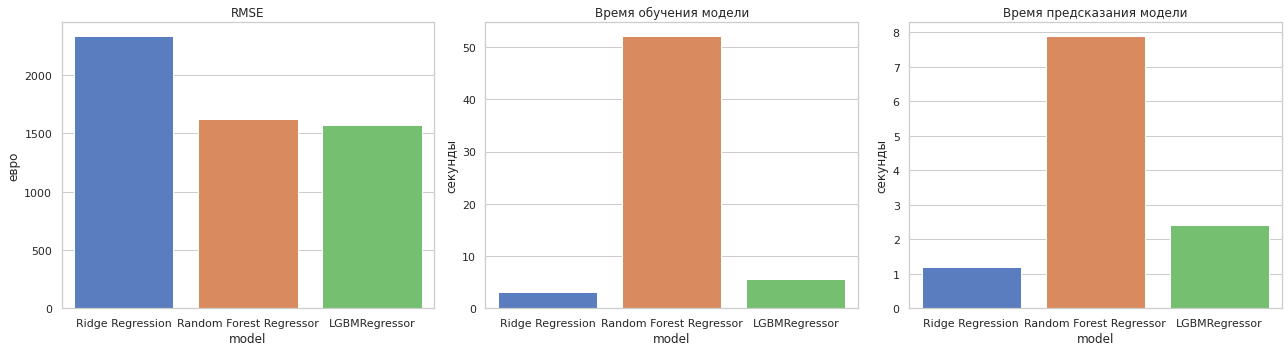

In [53]:
# Создание датафрейма с результатами моделей
models_results = pd.DataFrame({
    'model': ['Ridge Regression', 'Random Forest Regressor', 'LGBMRegressor'],
    'RMSE' : [ridge_rmse, random_forest_rmse, lgbr_rmse],
    'train_time': [ridge_train_time, random_forest_train_time, lgbr_train_time],
    'predict_time' : [ridge_pred_time, random_forest_pred_time, lgbrt_pred_time]
})

display(models_results)


# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
sns.barplot(x='model', y='RMSE', data=models_results, ax=axes[0], palette='muted')
axes[0].set_title('RMSE')
axes[0].set_ylabel('евро')

# Время обучения модели
sns.barplot(x='model', y='train_time', data=models_results, ax=axes[1], palette='muted')
axes[1].set_title('Время обучения модели')
axes[1].set_ylabel('секунды')

# Время предсказания модели
sns.barplot(x='model', y='predict_time', data=models_results, ax=axes[2], palette='muted')
axes[2].set_title('Время предсказания модели')
axes[2].set_ylabel('секунды')

plt.tight_layout()
plt.show()

- **LGBMRegressor** показывает наилучшее качество предсказаний с наименьшим значением RMSE (1572.52), что указывает на более точное определение рыночной стоимости автомобилей.
- **Ridge Regression** обучается быстрее всех (3.2 сек) и имеет минимальное время предсказания (1.2 сек), но её точность значительно ниже (RMSE 2334.97).
- **Random Forest Regressor** также имеет хорошую точность (RMSE 1627.25), но значительно дольше обучается (52.1 сек) и делает предсказания медленнее (7.89 сек).

Таким образом, модель **LGBMRegressor** является наилучшей по соотношению качества предсказания и времени, требуемого на обучение и предсказание. Проверим качество выбранной модели на тестовой выборке:

In [54]:
# Прогноз на тестовой выборке
y_test_pred = lgbr_model.predict(X_test)

# RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_test:.3f}')

Метрика RMSE на тестовой выборке: 1565.784


Метрика составила 1565.784 евро, т.е. отвечает запросу заказчика (*Значение метрики RMSE должно быть меньше 2500*).

#### Проверка адекватности модели

После выбора лучшей модели, важно оценить её адекватность. Для этого сравним результаты лучшей модели с базовой моделью — DummyRegressor, которая предсказывает константу. Это позволит понять, насколько предсказания сложной модели лучше базового решения.

In [55]:
# Обучение модели DummyRegressor
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_train, y_train)

# Получение предсказаний
y_dummy_pred = dummy_regr.predict(X_test)
rmse_dummy = mean_squared_error(y_test, y_dummy_pred, squared=False)

# Вывод результатов
print(f'RMSE DummyRegressor: {rmse_dummy:.3f}')
print(f'Разница между LGBMRegressor и DummyRegressor: {rmse_test - rmse_dummy:.3f}')

RMSE DummyRegressor: 4667.558
Разница между LGBMRegressor и DummyRegressor: -3101.774


Проверка адекватности показала, что RMSE для базовой модели, предсказывающей среднее, составил 4667.56. Разница между лучшей моделью (LGBMRegressor) и DummyRegressor составила -3101.77, что свидетельствует о значительном улучшении качества предсказаний. Это подтверждает, что использование более сложной модели, такой как LGBMRegressor, оправдано, и она значительно лучше базового предсказания константы.

## Общий вывод

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Предобработка данных**
- Было удалено 5 неинформативных признака.
- Обработаны пропущенные значения. 19 705 строк (5,56 % всех данных) было удалено. Оставшиеся пропуски были заменены на значение 'no_info'.
- Было удалено 26 370 полных дубликатов или 7.88 % от всех данных. Также были обработаны неявные дубликаты.
***

2) **Исследовательский анализ данных**
- Проанализировали распределение значений по каждому параметру, выявили средние значения, а также аномальные.
- Удалили 23,4 % от всех данных по причине ошибочности и аномальности значений.
- Выявили и удалили неинформативный для прогнозирования цены автомобиля признак - месяц регистрации автомобиля.
- Средняя стоимость автомобилей составляет 5 021 евро.
***
3) **Корреляционный анализ данных**
- Целевой признак price показал заметный уровень корреляции с признаками registration_year (коэффициент 0.644), model (0.562), power (0.453). С остальными признаками имеет умеренный и слабый уровень корреляции.
- Наличие мультиколлениарности между признаками brand и model (коэффициент 0.998). Удалять коррелирующие признаки не стали, т.к для обучения использовали модели менее чувствительные к мультиколлинеарности (не используют линейные зависимости между признаками).
***
4) **Обучение модели**

Для масштабирования числовых признаков был использован StandardScaler, для кодирования категориальных признаков - OneHotEncoder и OrdinalEncoder (в завимисоти от модели). Для подбора наилучших гиперпараметров для каждой модели был использован OptunaSearchCV.

В результате было обучено 3 модели: **Ridge Regression,  Random Forest Regresso, LGBMRegressor**. Для каждой модели рассчитана метрика RMSE, а также время, необходимое для обучения и предсказания модели.
***
5) **Анализ результатов**
- Наилучшее качество предсказаний с наименьшим значением RMSE (1572.52) показала **LGBMRegressor**.
- **Ridge Regression** обучается быстрее всех (3.2 сек) и имеет минимальное время предсказания (1.2 сек), но её точность значительно ниже (RMSE 2334.97).
- **Random Forest** Regressor также имеет хорошую точность (RMSE 1627.25), но значительно дольше обучается (52.1 сек) и делает предсказания медленнее (7.89 сек).

Исходя из полученных результатов, наилучшей  моделью была выбрана **LGBMRegressor**. На тестовой выборке показатель RMSE составил 1565.78 евро, т.е. удовлетворяющий критерию заказчика. 
***
6) **Итоги исследования**
- В ходе исследования была построена модель для предсказания рыночной стоимости автомобилей на основе технических характеристик, что позволит компании привлекать новых клиентов.
- Наилучшие результаты по качеству предсказания продемонстрировала модель **LGBMRegressor** с показателем RMSE 1565.78 на тестовой выборке. Эта модель соответствует критериям заказчика и показывает удовлетворительный уровень точности.

Результаты исследования помогут сервису принять обоснованные решения при разработке приложения, обеспечивая высокую точность оценок рыночной стоимости автомобилей. Это, в свою очередь, улучшит клиентский опыт и повысит конкурентоспособность компании на рынке.